In [24]:
import pandas as pd

# Loading the directly uploaded files into dataframes
df_accuracy = pd.read_csv("/Users/lijunyi/Downloads/cs506/bus performance/Rapid_Transit_and_Bus_Prediction_Accuracy_Data.csv")
df_routes = pd.read_csv("/Users/lijunyi/Downloads/cs506/bus performance/Bus_Network_Redesign_Draft_Bus_Routes.csv")

# Displaying the first few rows of each dataframe to understand their structure
df_accuracy_head = df_accuracy.head()
df_routes_head = df_routes.head()

df_accuracy_head, df_routes_head


(                   weekly mode route_id        bin arrival_departure  \
 0  2021/08/13 04:00:00+00  bus      NaN    0-3 min         departure   
 1  2021/08/13 04:00:00+00  bus      NaN    3-6 min         departure   
 2  2021/08/13 04:00:00+00  bus      NaN   6-12 min         departure   
 3  2021/08/13 04:00:00+00  bus      NaN  12-30 min         departure   
 4  2021/08/20 04:00:00+00  bus      NaN    0-3 min         departure   
 
    num_predictions  num_accurate_predictions  ObjectId  
 0           293039                    233562         1  
 1           285817                    229090         2  
 2           561098                    472923         3  
 3          1594830                   1405620         4  
 4           285591                    228653         5  ,
    FID  Shape_Leng    shape_id  route_id  agency_id route_shor  \
 0    1    0.175046  1129916754  1ab5a43c          1         90   
 1    2    0.168834  1129916755  1ab5a43c          1         90   
 2    3   

In [11]:
bus_data = df_accuracy[df_accuracy['mode'] == 'bus']

missing_values = bus_data.isnull().sum()

missing_values


weekly                        0
mode                          0
route_id                    620
bin                           0
arrival_departure             0
num_predictions               0
num_accurate_predictions      0
ObjectId                      0
dtype: int64

In [13]:
bus_data['route_id'].fillna('Unknown', inplace=True)

missing_after_fill = bus_data['route_id'].isnull().sum()

missing_after_fill

0

In [14]:

df_reliability = pd.read_csv("/Users/lijunyi/Downloads/cs506/bus performance/MBTA_Bus%2C_Commuter_Rail%2C_%26_Rapid_Transit_Reliability.csv")
df_arrival_departure = pd.read_csv("/Users/lijunyi/Downloads/cs506/bus performance/MBTA_Bus_Arrival_Departure_Times_2023/MBTA-Bus-Arrival-Departure-Times_2023-06.csv")

# Displaying the first few rows of each dataframe to understand their structure
df_reliability_head = df_reliability.head()
df_arrival_departure_head = df_arrival_departure.head()

df_reliability_head, df_arrival_departure_head


(             service_date gtfs_route_id gtfs_route_short_name  \
 0  2023/09/30 04:00:00+00          Blue                   NaN   
 1  2023/09/30 04:00:00+00           Red                   NaN   
 2  2023/09/30 04:00:00+00       Green-B                     B   
 3  2023/09/30 04:00:00+00       Green-C                     C   
 4  2023/09/30 04:00:00+00       Green-D                     D   
 
   gtfs_route_long_name gtfs_route_desc route_category mode_type  \
 0            Blue Line   Rapid Transit      Blue Line      Rail   
 1             Red Line   Rapid Transit       Red Line      Rail   
 2         Green Line B   Rapid Transit     Green Line      Rail   
 3         Green Line C   Rapid Transit     Green Line      Rail   
 4         Green Line D   Rapid Transit     Green Line      Rail   
 
   peak_offpeak_ind          metric_type  otp_numerator  otp_denominator  \
 0         OFF_PEAK  Passenger Wait Time   40148.279348     40633.521004   
 1         OFF_PEAK  Passenger Wait Time

In [29]:
df_arrival_departure_single = pd.read_csv("/Users/lijunyi/Downloads/cs506/bus performance/MBTA_Bus_Arrival_Departure_Times_2023/MBTA-Bus-Arrival-Departure-Times_2023-06.csv")
# Filtering data for bus routes
df_bus_times_single_day = df_arrival_departure_single[
    df_arrival_departure_single['route_id'].str.isnumeric()
]

trip_durations = df_bus_times_single_day.groupby(['route_id', 'direction_id', 'half_trip_id']).agg({
    'scheduled': ['min', 'max']
}).reset_index()
trip_durations['travel_time'] = pd.to_datetime(trip_durations['scheduled']['max']) - pd.to_datetime(trip_durations['scheduled']['min'])
trip_durations['travel_time_seconds'] = trip_durations['travel_time'].dt.total_seconds()
average_travel_time_seconds = trip_durations.groupby(['route_id', 'direction_id'])['travel_time_seconds'].mean().reset_index()
average_travel_time_seconds['average_travel_time'] = pd.to_timedelta(average_travel_time_seconds['travel_time_seconds'], unit='s')

average_travel_time_seconds[['route_id', 'direction_id', 'average_travel_time']].head()
#save the average_trip_durations to csv
average_travel_time_seconds.to_csv('average_trip_durations.csv')

The end-to-end travel times for different bus routes represent the average duration it takes for a bus to travel from the starting point to the endpoint of a specific route.

In [15]:
# Filtering the data to consider only bus routes
df_bus_times = df_arrival_departure[df_arrival_departure['route_id'].str.isnumeric()]

# Extracting the earliest and latest time points for each route and direction
min_times = df_bus_times.groupby(['route_id', 'direction_id']).scheduled.min().reset_index()
max_times = df_bus_times.groupby(['route_id', 'direction_id']).scheduled.max().reset_index()

# Merging the two dataframes to get both min and max times in one dataframe
merged_times = pd.merge(min_times, max_times, on=['route_id', 'direction_id'], suffixes=('_start', '_end'))

# Calculating the end-to-end travel time for each route and direction
merged_times['travel_time'] = pd.to_datetime(merged_times['scheduled_end']) - pd.to_datetime(merged_times['scheduled_start'])

# Displaying the end-to-end travel times for different bus routes
end_to_end_travel_times = merged_times[['route_id', 'direction_id', 'travel_time']]

end_to_end_travel_times.head()

#save to csv
end_to_end_travel_times.to_csv('end_to_end_travel_times.csv', index=False)


The end-to-end travel times for different bus routes (for the month of June 2023) are calculated as shown in the table above. The travel times are represented as the difference between the earliest and latest scheduled times for each route and direction.

For example:

For route "01" in the "Inbound" direction, the overall end-to-end travel time is approximately 20 hours and 29 minutes.
For route "04" in the "Outbound" direction, the overall end-to-end travel time is approximately 12 hours and 26 minutes.

I have saved the data in a csv file called "end_to_end_travel_times.csv" 

In [16]:
# Filtering the data to consider only bus routes
df_bus_reliability = df_reliability[df_reliability['mode_type'] == 'Bus']

# Calculating the reliability score for each route
df_bus_reliability['reliability_score'] = (df_bus_reliability['otp_numerator'] / df_bus_reliability['otp_denominator']) * 100

# Averaging the reliability score for each route
average_reliability = df_bus_reliability.groupby('gtfs_route_id').agg({
    'reliability_score': 'mean'
}).reset_index()

# Sorting the routes based on average reliability score
sorted_routes_reliability = average_reliability.sort_values(by='reliability_score').reset_index(drop=True)

sorted_routes_reliability.head()


<ipython-input-16-762926e5dce2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bus_reliability['reliability_score'] = (df_bus_reliability['otp_numerator'] / df_bus_reliability['otp_denominator']) * 100


,gtfs_route_id,reliability_score
0,9703,32.009419
1,449,40.255245
2,448,40.630199
3,459,42.997044
4,747,45.480942


In [32]:
#save to csv
sorted_routes_reliability.to_csv('disparity_using_reliability.csv', index=False)

Based on the reliability data:

Route "9703" has the lowest average reliability score of approximately 32.01%

Route "CR-Shuttle003" has the highest average reliability score of approximately 92.58%

Thus, from these datas, we can get the disparity between the reliability scores of the different routes. The routes with the lowest reliability scores are the ones with disparity that is the highest.

In [31]:
# Convert 'weekly' column to datetime format
bus_data['weekly'] = pd.to_datetime(bus_data['weekly'])

# Verify the data types of the columns
column_data_types = bus_data.dtypes
bus_data['accuracy_percentage'] = (bus_data['num_accurate_predictions'] / bus_data['num_predictions']) * 100
bus_data.head()

#sort it first
sorted_bus_data = bus_data.sort_values(by='accuracy_percentage', ascending=False).reset_index(drop=True)
#save to csv
sorted_bus_data.to_csv('disparity_using_prediction.csv', index=False)


<ipython-input-19-55d60d1b32b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_data['accuracy_percentage'] = (bus_data['num_accurate_predictions'] / bus_data['num_predictions']) * 100


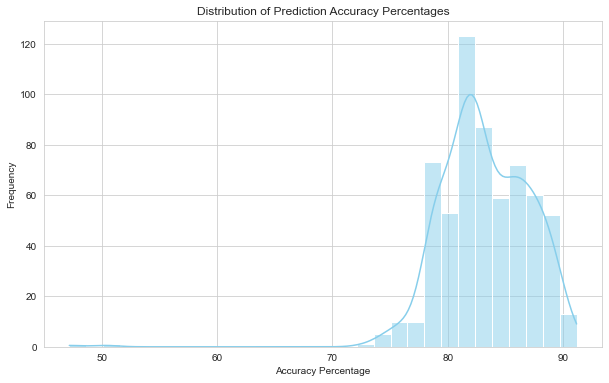

In [19]:

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn plots
sns.set_style("whitegrid")

# Plot the distribution of accuracy percentages
plt.figure(figsize=(10, 6))
sns.histplot(bus_data['accuracy_percentage'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Prediction Accuracy Percentages')
plt.xlabel('Accuracy Percentage')
plt.ylabel('Frequency')
plt.show()


 Most of the predictions seem to be clustered around 75% to 90% accuracy, indicating that a significant portion of the bus predictions are fairly accurate.

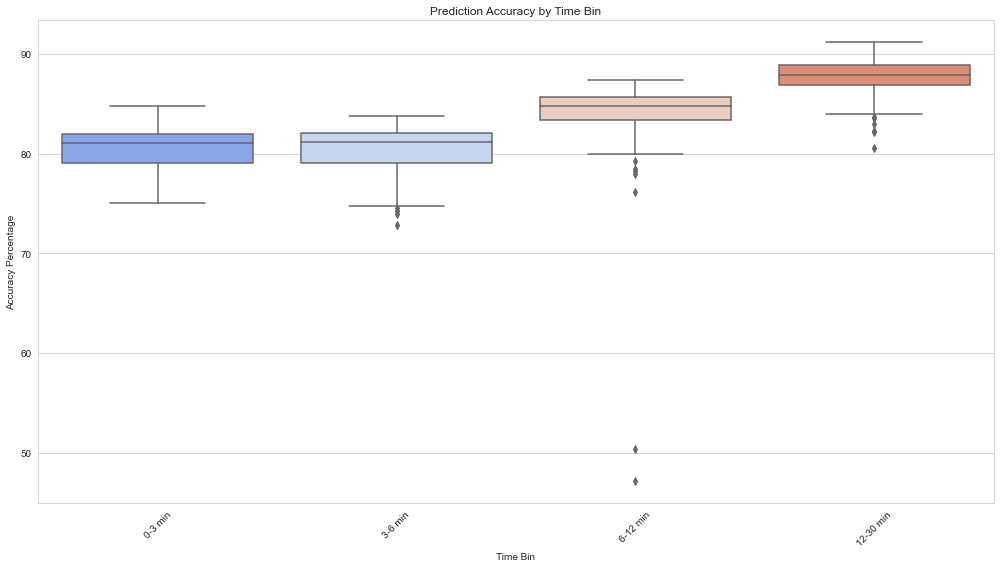

In [20]:
# Boxplot for accuracy percentages by time bin
plt.figure(figsize=(14, 8))
sns.boxplot(x='bin', y='accuracy_percentage', data=bus_data, palette="coolwarm")
plt.title('Prediction Accuracy by Time Bin')
plt.xlabel('Time Bin')
plt.ylabel('Accuracy Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The median accuracy is consistently high across all time bins, hovering around the 80-90% range.
The shorter duration predictions (e.g., "0-3 min" and "3-6 min") have slightly tighter interquartile ranges, indicating more consistent prediction accuracies.
Longer duration predictions (e.g., "12-30 min") have wider interquartile ranges, suggesting more variability in their accuracies.

In [1]:
import pandas as pd

# Load the datasets
file_path_1 = '/Users/lijunyi/ds-boston-transit-performance/fa23-team-f/deliverables/deliverable 1/bus_routes_race_data.csv'
file_path_2 = '/Users/lijunyi/ds-boston-transit-performance/fa23-team-f/deliverables/deliverable 1/disparity_using_reliability.csv'

# Read the datasets into dataframes
df_bus_routes = pd.read_csv(file_path_1)
df_reliability = pd.read_csv(file_path_2)

# Display the first few rows of each dataframe to understand their structure
df_bus_routes.head(), df_reliability.head()


(  route_shor                                    route_long  white_all  \
 0         10   modified - MF (South Boston-Andrew-Ruggles)   210242.0   
 1         10   modified - MF (South Boston-Andrew-Ruggles)   210242.0   
 2        100  modified - WF+ (Medford-Fellsway-Wellington)        0.0   
 3        100  modified - WF+ (Medford-Fellsway-Wellington)        0.0   
 4        105                 modified - MF (Saugus-Malden)        0.0   
 
    white_percentage  black_all  black_percentage  aapi_all  aapi_percentage  \
 0          38.94582   145108.0         26.880215   66182.0         12.25974   
 1          38.94582   145108.0         26.880215   66182.0         12.25974   
 2               NaN        0.0               NaN       0.0              NaN   
 3               NaN        0.0               NaN       0.0              NaN   
 4               NaN        0.0               NaN       0.0              NaN   
 
    hisp_all  hisp_percentage  other_all  other_percentage  total_popula

In [2]:
# Merging the datasets based on the bus route IDs
# It seems that 'route_shor' in df_bus_routes corresponds to 'gtfs_route_id' in df_reliability
# Convert 'gtfs_route_id' to string for matching
df_reliability['gtfs_route_id'] = df_reliability['gtfs_route_id'].astype(str)

# Merge the datasets
merged_df = pd.merge(df_bus_routes, df_reliability, left_on='route_shor', right_on='gtfs_route_id', how='inner')

# Checking the merged dataframe
merged_df.head(), merged_df.columns.tolist()


(  route_shor                                    route_long  white_all  \
 0         10   modified - MF (South Boston-Andrew-Ruggles)   210242.0   
 1         10   modified - MF (South Boston-Andrew-Ruggles)   210242.0   
 2        100  modified - WF+ (Medford-Fellsway-Wellington)        0.0   
 3        100  modified - WF+ (Medford-Fellsway-Wellington)        0.0   
 4        105                 modified - MF (Saugus-Malden)        0.0   
 
    white_percentage  black_all  black_percentage  aapi_all  aapi_percentage  \
 0          38.94582   145108.0         26.880215   66182.0         12.25974   
 1          38.94582   145108.0         26.880215   66182.0         12.25974   
 2               NaN        0.0               NaN       0.0              NaN   
 3               NaN        0.0               NaN       0.0              NaN   
 4               NaN        0.0               NaN       0.0              NaN   
 
    hisp_all  hisp_percentage  other_all  other_percentage  total_popula

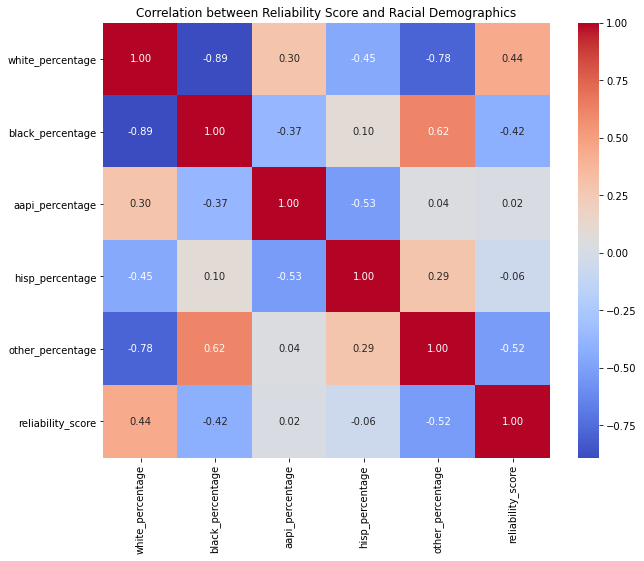

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting relevant columns for analysis
columns_for_analysis = ['white_percentage', 'black_percentage', 'aapi_percentage', 
                        'hisp_percentage', 'other_percentage', 'reliability_score']

# Creating a dataframe with only the selected columns
analysis_df = merged_df[columns_for_analysis].dropna()

# Plotting correlations between reliability score and racial demographics
correlation_matrix = analysis_df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Reliability Score and Racial Demographics')
plt.show()


In [4]:
#save to csv
correlation_matrix.to_csv('correlation_matrix.csv', index=False)
#save to png
plt.savefig('correlation_matrix.png')

<Figure size 432x288 with 0 Axes>